In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import io
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [129]:
save_dir = "/mnt/data/jmarkow/panels/2024-06 (QD paper)"

In [130]:
csv= "/home/jmarkow/data_dir/active_projects/quantum_dots/misc/qdot_spectra/Qdot 800.csv"

In [131]:
df = pd.read_csv(csv).set_index("Wavelength")

In [132]:
sns.set_context("paper")

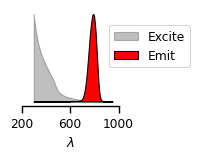

In [133]:
fig, ax = plt.subplots(1, figsize=(1.25,1.25))
ax.fill_between(df.index, df["Excitation"].values, fc="k", ec="k",alpha=.25, label="Excite")
ax.fill_between(df.index, df["Emission"].values, fc="r", ec="k", label="Emit")
ax.legend(bbox_to_anchor=(1.8, .9))
ax.spines[["left", "right", "top"]].set_visible(False)
ax.set_yticks([])
ax.set_xticks([200,600,1000])
ax.set_xlabel("$\lambda$")
fig.savefig(os.path.join(save_dir, "qdot800_spectra_thermo.pdf"), bbox_inches="tight")
# sns.despine(offset=5)


In [134]:
exp_decay = lambda x, tau: np.exp(-x/tau)

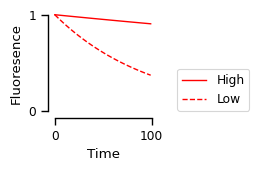

In [135]:
fig, ax = plt.subplots(1, figsize=(1.25, 1.25))
ax.plot(exp_decay(np.arange(100), 1000), clip_on=False, color="r", lw=1, label="High")
ax.plot(exp_decay(np.arange(100), 100), clip_on=False, color="r", ls="--", lw=1, label="Low")
ax.spines[["top","right"]].set_visible(False)
ax.set_yticks([0,1])
ax.set_ylim(0,1)
ax.set_xticks([0, 100])
ax.set_xlim(0,100)
ax.set_ylim(0,1)
ax.set_xlabel("Time")
ax.set_ylabel("Fluoresence")
ax.legend(bbox_to_anchor=(1.2, .5))
sns.despine(offset=5)
fig.savefig(os.path.join(save_dir, "qdot_photostability.pdf"), bbox_inches="tight")


In [136]:
# temporal multiplexing

In [137]:
# load in metadata file and use to derive schematic...

In [138]:
import toml

In [139]:
metadata_fname = "/home/jmarkow/data_dir/active_projects/quantum_dots/timecourse_01/session_20231204114743-438357 (system76-pc)/metadata.toml"

In [140]:
metadata = toml.load(metadata_fname)

In [141]:
trigger_hi = np.array(metadata["cli_parameters"]["hw_trigger_pulse_width"]) # reflect then fluo
trigger_lo = np.array(metadata["cli_parameters"]["hw_trigger_pulse_low"])

In [142]:
trigger_hi

array([0.01 , 0.023])

In [143]:
fs = 5000
samples_hi = {}
samples_lo = {}
samples_hi["reflect"] = np.round(trigger_hi[0] * fs).astype("int")
samples_hi["fluo"] = np.round(trigger_hi[1] * fs).astype("int")
samples_lo["reflect"] = np.round(trigger_lo[0] * fs).astype("int")
samples_lo["fluo"] = np.round(trigger_lo[1] * fs).astype("int")

In [144]:
# one cycle is hi then lo then other hi + lo
cycles = {}
cycles["reflect"] = []
cycles["reflect"] += [1 for _ in range(samples_hi["reflect"])]
cycles["reflect"] += [0 for _ in range(samples_lo["reflect"])]
cycles["reflect"] += [0 for _ in range(samples_lo["fluo"] + samples_hi["fluo"])]


In [145]:
cycles["fluo"] = []
cycles["fluo"] += [0 for _ in range(samples_lo["reflect"] + samples_hi["reflect"])]
cycles["fluo"] += [1 for _ in range(samples_hi["fluo"])]
cycles["fluo"] += [0 for _ in range(samples_lo["fluo"])]

In [146]:
ncycles = 7

In [147]:
plt_fluo = cycles["fluo"] * ncycles
plt_reflect = cycles["reflect"] * ncycles


In [148]:
# include scale bar...

In [149]:
scale_bar = .03

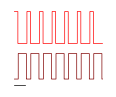

In [150]:
fig, ax = plt.subplots(2,1, figsize=(1.25,1), sharex=True)
ax[1].step(np.arange(len(plt_fluo)), plt_fluo, color=[.5, 0, 0], lw=.5)
ax[0].step(np.arange(len(plt_fluo)), plt_reflect, color=[1, 0, 0], lw=.5)
ax[1].plot([0, scale_bar * fs],[-.25,-.25],"k-", clip_on=False, lw=.5)
for _ax in ax:
    _ax.axis("off")

fig.savefig(os.path.join(save_dir, "multiplex_schematic.pdf"), bbox_inches="tight")


In [151]:
# load in some data samples to show w/ the excitation pattern...

In [152]:
# which data to load?

In [153]:
# interlace reflect, fluo, etc...

In [154]:
ncycles = 3

In [155]:
full_cycle = (trigger_hi + trigger_lo).sum()

In [156]:
2 % 2

0

In [157]:
from qd_analysis.util import load_example_frames
from tqdm.auto import tqdm
import glob

In [158]:
base_dir = "/mnt/data/jmarkow/active_projects/quantum_dots/timecourse_01"
fluo_files = sorted(glob.glob(os.path.join(base_dir, "**", "Basler*fluorescence.avi"), recursive=True))

In [159]:
calibration_data = toml.load("/home/jmarkow/data_dir/active_projects/quantum_dots/timecourse_01_calibration.toml")

In [160]:
# get subject names and filter that stuff...
metadata = {}
dirs = sorted(list(set([os.path.dirname(_) for _ in fluo_files])))
for _dir in tqdm(dirs):
    metadata[_dir] = toml.load(os.path.join(_dir, "../metadata.toml"))

  0%|          | 0/90 [00:00<?, ?it/s]

In [161]:
keep_dirs_qd_exp = sorted([
    _file
    for _file in metadata.keys()
    if "qd_exp_01" in metadata[_file]["user_input"]["subject"].lower()
])

In [162]:
cameras = sorted(list(list(metadata.values())[0]["cameras"].keys()))

In [163]:
load_dct = {}
for _cam in cameras:
    load_dct[_cam] = {}
    load_dct[_cam]["intrinsic_matrix"] = np.array(calibration_data["intrinsics"][_cam])
    load_dct[_cam]["distortion_coeffs"] = np.array(calibration_data["distortion_coeffs"][_cam] )

In [164]:
use_dir = keep_dirs_qd_exp[0]
use_metadata = toml.load(os.path.join(use_dir, "..", "metadata.toml"))
cameras = list(use_metadata["camera_metadata"].keys())

In [165]:
load_cameras = cameras

In [166]:
# get a blank and a high intensity animal...
(
    fluo_frames,
    reflect_frames,
    _,
    timestamps["cell_labeling"],
    fluo_bgrounds["cell_labeling"],
) = load_example_frames(use_dir, frame_range=range(100,110), bground_subtract_fluorescence=False, load_cameras=load_cameras, load_dct=load_dct) # 0 looks pretty good...


/home/jmarkow/dev/python/markovids/src/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/home/jmarkow/dev/python/markovids/src/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/home/jmarkow/dev/python/markovids/src/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/home/jmarkow/dev/python/markovids/src/markovids/vid/io.py:552: UserWarning: No intrinsic matrix or distortion coefficients, skipping undistortion
  warnings.warn("No intrinsic matrix or distortion coefficients, skipping undistortion")
/home/jmarkow/dev/python/markovids/src/markovids/vid/io.

In [167]:
reflect_kwargs = {"cmap": "gray", "vmin": 0, "vmax": 125}
fluo_kwargs = {"cmap": "magma", "vmin": 0, "vmax": 75}

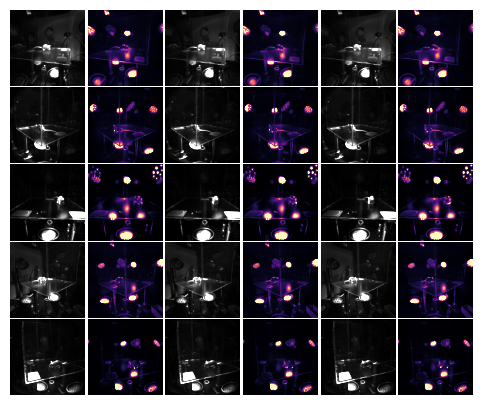

In [173]:
fig, ax = plt.subplots(len(cameras), ncycles * 2, figsize=(ncycles * 2,len(cameras)), sharex=True, sharey=True)
for rax, _cam in zip(ax, cameras):
    for i, _ax in enumerate(rax):
        frame_idx = i // 2
        if i % 2 == 0:
            _ax.imshow(reflect_frames[_cam][frame_idx], **reflect_kwargs)
        else:
            _ax.imshow(fluo_frames[_cam][frame_idx], **fluo_kwargs)

for _ax in ax.ravel():
    _ax.axis("off")

fig.subplots_adjust(hspace=.015, wspace=.01)
fig.savefig(os.path.join(save_dir, "multiplex_schematic_frames.pdf"), bbox_inches="tight", dpi=600)


In [169]:
exposures_fluo = np.array(plt_fluo)
exposures_fluo = exposures_fluo.astype("float")
exposures_fluo[exposures_fluo==0] = np.nan

In [170]:
exposures_reflect = np.array(plt_reflect)
exposures_reflect = exposures_reflect.astype("float")
exposures_reflect[exposures_reflect==0] = np.nan

In [171]:
scale_bar

0.03

In [182]:
full_cycle * 3

0.10650000000000001

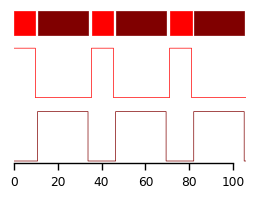

In [189]:
fig, ax = plt.subplots(3,1, figsize=(3,2), height_ratios=[1,2,2], sharex=True, sharey=True)
ax[0].fill_between(np.arange(len(plt_fluo)) / fs * 1e3, exposures_fluo, color=[.5,0,0], lw=.5, alpha=1)
ax[0].fill_between(np.arange(len(plt_fluo)) / fs * 1e3, exposures_reflect, color=[1.,0,0], lw=.5, alpha=1)
ax[2].step(np.arange(len(plt_fluo)) / fs * 1e3, plt_fluo, color=[.5, 0, 0], lw=.5)
ax[1].step(np.arange(len(plt_fluo)) / fs * 1e3, plt_reflect, color=[1, 0, 0], lw=.5)
# ax[2].plot([0, scale_bar * fs],[-.25,-.25],"k-", clip_on=False, lw=.5)
ax[1].set_xlim(0, 106)
ax[2].set_yticks([])
for _ax in ax[:-1]:
    _ax.axis("off")
sns.despine(trim=True)
ax[2].spines[["top","right","left"]].set_visible(False)

fig.savefig(os.path.join(save_dir, f"multiplex_schematic_exposures_scale-{scale_bar * 1e3}ms.pdf"), bbox_inches="tight")
